# Librerias

In [1]:
# imports time series
import pandas as pd
import numpy as np
import seaborn as sns

# plots
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

from prophet import Prophet

import time

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

sns.set_style('white')


pd.options.display.float_format = '{:,.2f}'.format


#--------------------------------------------------------
# imports best practice sklearn
import sklearn
from sklearn import set_config

from sklearn.tree import DecisionTreeClassifier

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model selection e hiperparameters optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold

from sklearn.metrics import accuracy_score

from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.cluster import KMeans


# Carga Dataset

In [2]:
#PC DE FRANCESC
DATA_PATH = 'C://Users//Usuario//OneDrive//Workplace//Portfolio_Projects//TFM_DSC_Easy_Money//data//'

In [3]:
df_completo_sales = pd.read_csv(os.path.join(DATA_PATH, "df_completo_salesv2.csv"))

In [4]:
df_completo_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   unnamed: 0          240773 non-null  int64  
 1   pk_sale             240773 non-null  int64  
 2   pk_cid              240773 non-null  int64  
 3   pk_partition        240773 non-null  object 
 4   pk_product_id       240773 non-null  int64  
 5   net_margin          240773 non-null  float64
 6   product_desc        240773 non-null  object 
 7   family_product      240773 non-null  object 
 8   short_term_deposit  240773 non-null  int64  
 9   loans               240773 non-null  int64  
 10  mortgage            240773 non-null  int64  
 11  funds               240773 non-null  int64  
 12  securities          240773 non-null  int64  
 13  long_term_deposit   240773 non-null  int64  
 14  em_account_pp       240773 non-null  int64  
 15  credit_card         240773 non-nul

In [5]:
df_completo_sales.head().T

,0,1,2,3,4
unnamed: 0,123338,123339,123340,72175,84498
pk_sale,130004,130005,130006,78841,91164
pk_cid,15891,16203,16502,16502,17457
pk_partition,2018-07,2019-01,2018-10,2019-01,2018-09
pk_product_id,4657,4657,4657,8871,3819
net_margin,66.40,96.70,64.30,68.60,56.00
product_desc,em_acount,em_acount,em_acount,emc_account,debit_card
family_product,account,account,account,account,payment_card
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0


In [6]:
df_completo_sales["pk_partition"] = pd.to_datetime(df_completo_sales["pk_partition"], format="%Y-%m")
df_completo_sales["entry_date"] = pd.to_datetime(df_completo_sales["entry_date"], format="%Y-%m-%d")

In [7]:
df_completo_sales.drop(columns=['unnamed: 0'], inplace=True)

In [8]:
df_completo_sales.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Columns: 38 entries, pk_sale to productos_baja
dtypes: datetime64[ns](2), float64(7), int64(21), object(8)
memory usage: 69.8+ MB


# Tratamiento Outliers Salary

    Hemos visto que cuando realizamos la segmentación, obtenemos dos cluster que contienen entre los dos únicamente 239 registros frente a los 
    240772, que es insigmificante, con lo que podemos eliminar estos registros. Se identifican muy fácilmente ya que tienen salarios muy elevados respecto a la media. 
    Vamos a elimnar los registros que tienen más de 1500000 # de salario (representan el 0,11 %)

In [9]:
clientes_high_salary=df_completo_sales[(df_completo_sales['salary']>=1500000)]

In [10]:
clientes_high_salary

,pk_sale,pk_cid,pk_partition,pk_product_id,net_margin,product_desc,family_product,short_term_deposit,loans,mortgage,...,entry_date,entry_channel,active_customer,segment,Provincia,cliente_nuevo,tipo_cliente,productos_nuevos,productos_activos,productos_baja
1322,130400,409025,2018-07-01,4657,55.30,em_acount,account,0,0,0,...,2016-02-01,KAT,1.00,02 - PARTICULARES,Madrid,0,Antiguo,1,1.00,NaN
1528,130466,473241,2018-12-01,4657,85.90,em_acount,account,0,0,0,...,2018-12-01,KHM,1.00,02 - PARTICULARES,Madrid,1,Nuevo,1,1.00,NaN
1529,79024,473241,2019-04-01,8871,68.50,emc_account,account,0,0,0,...,2018-12-01,KFC,1.00,02 - PARTICULARES,Madrid,0,Antiguo,1,2.00,NaN
2814,91579,795391,2018-06-01,3819,60.30,debit_card,payment_card,0,0,0,...,2016-09-01,KAT,1.00,02 - PARTICULARES,Madrid,0,Antiguo,1,2.00,NaN
3278,131047,861180,2019-04-01,4657,70.40,em_acount,account,0,0,0,...,2019-03-01,KHM,0.00,02 - PARTICULARES,Madrid,0,Antiguo,1,1.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232059,241065,1537207,2019-03-01,4657,69.90,em_acount,account,0,0,0,...,2019-03-01,KFC,1.00,02 - PARTICULARES,Vizcaya,1,Nuevo,1,1.00,NaN
233994,242274,1539852,2019-03-01,4657,84.10,em_acount,account,0,0,0,...,2019-03-01,KFC,1.00,02 - PARTICULARES,Vizcaya,1,Nuevo,1,1.00,NaN
234223,242433,1540183,2019-04-01,4657,54.60,em_acount,account,0,0,0,...,2019-03-01,KHM,1.00,02 - PARTICULARES,Vizcaya,0,Antiguo,1,1.00,NaN
235242,243147,1541631,2019-03-01,4657,56.00,em_acount,account,0,0,0,...,2019-03-01,KHN,1.00,02 - PARTICULARES,Zaragoza,1,Nuevo,1,1.00,NaN


In [11]:
df_completo_sales = df_completo_sales[(df_completo_sales['salary']<=1500000)]

In [12]:
df_completo_sales

,pk_sale,pk_cid,pk_partition,pk_product_id,net_margin,product_desc,family_product,short_term_deposit,loans,mortgage,...,entry_date,entry_channel,active_customer,segment,Provincia,cliente_nuevo,tipo_cliente,productos_nuevos,productos_activos,productos_baja
0,130004,15891,2018-07-01,4657,66.40,em_acount,account,0,0,0,...,2018-07-01,KAT,1.00,02 - PARTICULARES,Madrid,1,Nuevo,1,1.00,NaN
1,130005,16203,2019-01-01,4657,96.70,em_acount,account,0,0,0,...,2018-12-01,KAT,1.00,02 - PARTICULARES,Barcelona,0,Antiguo,1,1.00,NaN
2,130006,16502,2018-10-01,4657,64.30,em_acount,account,0,0,0,...,2018-09-01,KHN,1.00,02 - PARTICULARES,Madrid,0,Antiguo,1,1.00,NaN
3,78841,16502,2019-01-01,8871,68.60,emc_account,account,0,0,0,...,2018-09-01,KHN,1.00,02 - PARTICULARES,Madrid,0,Antiguo,1,2.00,NaN
4,91164,17457,2018-09-01,3819,56.00,debit_card,payment_card,0,0,0,...,2017-09-01,KAT,1.00,02 - PARTICULARES,Madrid,0,Antiguo,1,3.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240768,247434,1553456,2019-05-01,4657,56.70,em_acount,account,0,0,0,...,2019-05-01,KHM,1.00,02 - PARTICULARES,Madrid,1,Nuevo,1,1.00,NaN
240769,247435,1553541,2019-05-01,4657,66.50,em_acount,account,0,0,0,...,2019-05-01,KHN,1.00,02 - PARTICULARES,Zamora,1,Nuevo,1,1.00,NaN
240770,247436,1553559,2019-05-01,4657,73.00,em_acount,account,0,0,0,...,2019-05-01,KFC,1.00,02 - PARTICULARES,Barcelona,1,Nuevo,1,1.00,NaN
240771,247437,1553565,2019-05-01,4657,82.30,em_acount,account,0,0,0,...,2019-05-01,KHM,0.00,02 - PARTICULARES,Toledo,1,Nuevo,1,1.00,NaN


# Preparación Segmentación

In [13]:
# Seleccionamos los clientes actuales, es decir, los que nos da la última partición

In [14]:
# clientes_actuales=df_completo_sales[(df_completo_sales['pk_partition']=='2019-05-01 00:00:00') &
#           (df_completo_sales['active_customer']==1)]

In [15]:
# Seleccionamos la última fecha registrada por cliente
clientes_actuales = df_completo_sales.drop_duplicates(subset=['pk_cid'], keep='last')

In [16]:
clientes_actuales.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 152619 entries, 0 to 240772
Columns: 38 entries, pk_sale to productos_baja
dtypes: datetime64[ns](2), float64(7), int64(21), object(8)
memory usage: 45.4+ MB


In [17]:
# active_customer = 0
# clientes_actuales.info(verbose=False)

In [18]:
# clientes_antiguos=df_completo_sales[(df_completo_sales['pk_partition']=='2019-05-01 00:00:00') &
#          (df_completo_sales['active_customer']==0)]

In [19]:
# clientes_antiguos.info(verbose=False)

In [20]:
clientes_actuales.head().T

,0,1,3,4,6
pk_sale,130004,130005,78841,91164,12022
pk_cid,15891,16203,16502,17457,17970
pk_partition,2018-07-01 00:00:00,2019-01-01 00:00:00,2019-01-01 00:00:00,2018-09-01 00:00:00,2019-02-01 00:00:00
pk_product_id,4657,4657,8871,3819,2673
net_margin,66.40,96.70,68.60,56.00,830.30
product_desc,em_acount,em_acount,emc_account,debit_card,securities
family_product,account,account,account,payment_card,investment
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0


# Creación de variables

    # Total Productos contratados

In [21]:
listado_productos = ['short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'em_account_pp',
       'credit_card', 'payroll','pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_account_p', 'em_acount']

In [22]:
clientes_actuales_melted = clientes_actuales.melt(id_vars=['pk_cid','pk_sale'],value_vars=listado_productos,var_name='Producto', value_name='Productos')

In [23]:
clientes_actuales_melted=clientes_actuales_melted.groupby(['pk_cid','pk_sale']).agg({'Productos':np.sum}).reset_index(drop=False)

In [24]:
clientes_actuales_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152619 entries, 0 to 152618
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   pk_cid     152619 non-null  int64
 1   pk_sale    152619 non-null  int64
 2   Productos  152619 non-null  int64
dtypes: int64(3)
memory usage: 3.5 MB


In [25]:
clientes_actuales_melted.head(12).T

,0,1,2,3,4,5,6,7,8,9,10,11
pk_cid,15891,16203,16502,17457,17970,17980,18146,20243,20333,21719,22212,22635
pk_sale,130004,130005,78841,91164,12022,13179,78842,78843,17406,130007,91166,78844
Productos,1,1,2,3,5,2,1,1,3,2,2,2


In [26]:
clientes_actuales_final=pd.merge(clientes_actuales,clientes_actuales_melted, how="inner",on=['pk_cid','pk_sale'])

In [27]:
clientes_actuales_final['Productos'].value_counts().to_frame()

,count
Productos,
1,90673
2,35006
3,12411
4,9780
5,3287
6,1161
7,234
8,56
9,11


In [28]:
clientes_actuales_final.sample(8).T

,93961,80381,68210,148673,124481,72568,74802,34708
pk_sale,74891,176691,164592,243577,220270,168933,171156,14680
pk_cid,1451507,1432022,1415710,1542550,1497753,1421424,1424345,1306332
pk_partition,2019-03-01 00:00:00,2018-08-01 00:00:00,2018-07-01 00:00:00,2019-04-01 00:00:00,2018-12-01 00:00:00,2018-08-01 00:00:00,2018-08-01 00:00:00,2019-01-01 00:00:00
pk_product_id,2235,4657,4657,4657,4657,4657,4657,2336
net_margin,76.70,62.90,61.90,81.10,66.90,79.40,66.80,983.20
product_desc,payroll_account,em_acount,em_acount,em_acount,em_acount,em_acount,em_acount,long_term_deposit
family_product,account,account,account,account,account,account,account,investment
short_term_deposit,0,0,0,0,0,0,0,0
loans,0,0,0,0,0,0,0,0
mortgage,0,0,0,0,0,0,0,0


    # Total Cuentas_Contratadas

In [29]:
listado_cuentas  = ['em_account_pp', 'payroll','payroll_account',
       'emc_account', 'em_account_p', 'em_acount']

In [30]:
clientes_actuales_melted = clientes_actuales_final.melt(id_vars=['pk_cid','pk_sale'],value_vars=listado_cuentas,var_name='Cuenta', value_name='Cuentas')
clientes_actuales_melted=clientes_actuales_melted.groupby(['pk_cid','pk_sale']).agg({'Cuentas':np.sum}).reset_index(drop=False)
clientes_actuales_final=pd.merge(clientes_actuales_final,clientes_actuales_melted, how="inner",on=['pk_cid','pk_sale'])

In [31]:
clientes_actuales_final['Cuentas'].value_counts().to_frame()

,count
Cuentas,
1,120765
2,24959
3,3737
0,2906
4,252


    # Total Tarjetas_Contratadas

In [32]:
listado_tarjetas = ['credit_card','debit_card']

In [33]:
clientes_actuales_melted = clientes_actuales_final.melt(id_vars=['pk_cid','pk_sale'],value_vars=listado_tarjetas,var_name='Tarjeta', value_name='Tarjetas')
clientes_actuales_melted=clientes_actuales_melted.groupby(['pk_cid','pk_sale']).agg({'Tarjetas':np.sum}).reset_index(drop=False)
clientes_actuales_final=pd.merge(clientes_actuales_final,clientes_actuales_melted, how="inner",on=['pk_cid','pk_sale'])

In [34]:
clientes_actuales_final['Tarjetas'].value_counts().to_frame()

,count
Tarjetas,
0,106342
1,42478
2,3799


    # Total Inversión

In [35]:
listado_inversion = ['short_term_deposit','long_term_deposit','securities','funds']

In [36]:
clientes_actuales_melted = clientes_actuales_final.melt(id_vars=['pk_cid','pk_sale'],value_vars=listado_inversion,var_name='Inversion', value_name='Inversiones')
clientes_actuales_melted=clientes_actuales_melted.groupby(['pk_cid','pk_sale']).agg({'Inversiones':np.sum}).reset_index(drop=False)
clientes_actuales_final=pd.merge(clientes_actuales_final,clientes_actuales_melted, how="inner",on=['pk_cid','pk_sale'])

In [37]:
clientes_actuales_final['Inversiones'].value_counts().to_frame()

,count
Inversiones,
0,143757
1,8142
2,672
3,48


    # Total Créditos Contratados

In [38]:
listado_creditos = ['loans','mortgage']

In [39]:
clientes_actuales_melted = clientes_actuales_final.melt(id_vars=['pk_cid','pk_sale'],value_vars=listado_creditos,var_name='Credito', value_name='Creditos')
clientes_actuales_melted=clientes_actuales_melted.groupby(['pk_cid','pk_sale']).agg({'Creditos':np.sum}).reset_index(drop=False)
clientes_actuales_final=pd.merge(clientes_actuales_final,clientes_actuales_melted, how="inner",on=['pk_cid','pk_sale'])

In [40]:
clientes_actuales_final['Creditos'].value_counts().to_frame()

,count
Creditos,
0,152579
1,40


    # Total Planes Pensiones Contratados

In [41]:
listado_pensiones = ['pension_plan']

In [42]:
clientes_actuales_melted = clientes_actuales_final.melt(id_vars=['pk_cid','pk_sale'],value_vars=listado_pensiones,var_name='Pension', value_name='Pensiones')
clientes_actuales_melted=clientes_actuales_melted.groupby(['pk_cid','pk_sale']).agg({'Pensiones':np.sum}).reset_index(drop=False)
clientes_actuales_final=pd.merge(clientes_actuales_final,clientes_actuales_melted, how="inner",on=['pk_cid','pk_sale'])

In [43]:
clientes_actuales_final['Pensiones'].value_counts().to_frame()

,count
Pensiones,
0,132643
1,19976


In [44]:
clientes_actuales_final.head().T

,0,1,2,3,4
pk_sale,130004,130005,78841,91164,12022
pk_cid,15891,16203,16502,17457,17970
pk_partition,2018-07-01 00:00:00,2019-01-01 00:00:00,2019-01-01 00:00:00,2018-09-01 00:00:00,2019-02-01 00:00:00
pk_product_id,4657,4657,8871,3819,2673
net_margin,66.40,96.70,68.60,56.00,830.30
product_desc,em_acount,em_acount,emc_account,debit_card,securities
family_product,account,account,account,payment_card,investment
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0


# SEGMENTACION

In [45]:
lista_variables = ["Productos", "Cuentas", "Tarjetas", "Inversiones","Creditos","Pensiones","age","salary","net_margin", "cliente_nuevo"]

In [46]:
df_final = clientes_actuales_final[lista_variables]

In [47]:
df_final

,Productos,Cuentas,Tarjetas,Inversiones,Creditos,Pensiones,age,salary,net_margin,cliente_nuevo
0,1,1,0,0,0,0,59,"183,352.59",66.40,1
1,1,1,0,0,0,0,70,"61,583.07",96.70,0
2,2,2,0,0,0,0,58,"145,595.40",68.60,0
3,3,1,1,1,0,0,53,"102,405.75",56.00,0
4,5,2,1,1,0,1,75,"118,137.69",830.30,0
...,...,...,...,...,...,...,...,...,...,...
152614,1,1,0,0,0,0,32,"43,156.29",56.70,1
152615,1,1,0,0,0,0,54,"132,758.10",66.50,1
152616,1,1,0,0,0,0,43,"97,924.89",73.00,1
152617,1,1,0,0,0,0,68,"34,554.21",82.30,1


In [48]:
pipe = Pipeline(
        steps=[
            ("Imputer", KNNImputer()),
            ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
            #('StandardScaler', StandardScaler()),
        ]
)

In [49]:
pipe.fit(df_final)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('RobustScaler', RobustScaler(quantile_range=(0, 99.0)))])

In [50]:
df_scaled_transformed = pipe.fit_transform(df_final)

In [51]:
sse = {}

for k in range(2, 20):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_scaled_transformed)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters


Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Fitting pipe with 15 clusters
Fitting pipe with 16 clusters
Fitting pipe with 17 clusters
Fitting pipe with 18 clusters
Fitting pipe with 19 clusters


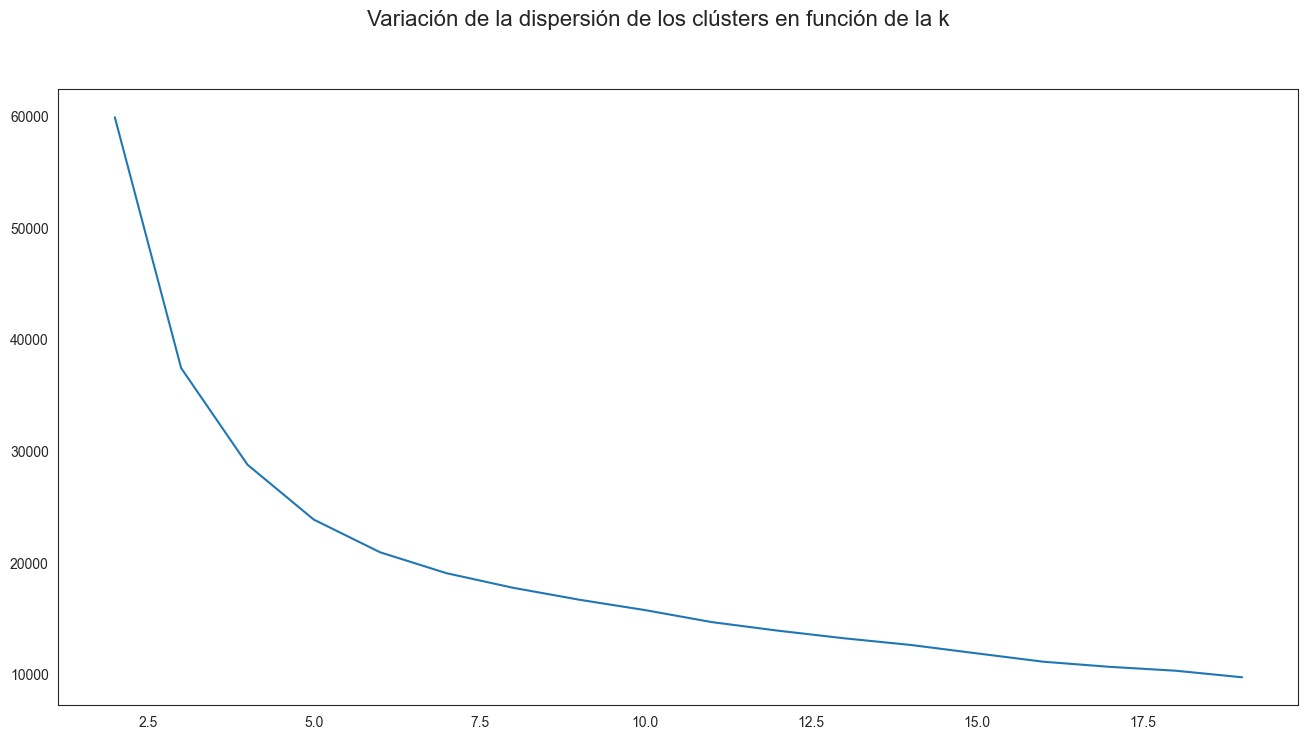

In [52]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

In [53]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),   
    #('StandardScaler', StandardScaler()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 5, random_state = 175))
])

In [54]:
pipe.fit(df_final)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=5, random_state=175))])

In [55]:
clientes_actuales_final['Cluster'] = pipe.predict(df_final)

In [56]:
df = clientes_actuales_final.groupby('Cluster').agg({
                                        'Productos':np.mean,
                                        'Cuentas':np.mean,
                                        'Tarjetas':np.mean, 
                                        'Inversiones':np.mean,
                                        'Creditos':np.mean,
                                        'Pensiones':np.mean,
                                        'age':np.mean,
                                        'salary':np.mean,
                                        'net_margin':np.mean,                                        
                                        'cliente_nuevo':np.mean,
                                        'Cluster':len                                 
                                        })

In [57]:
df["Ingresos"]=df["Productos"]*df["net_margin"]*df["Cluster"]

In [58]:
df

,Productos,Cuentas,Tarjetas,Inversiones,Creditos,Pensiones,age,salary,net_margin,cliente_nuevo,Cluster,Ingresos
Cluster,,,,,,,,,,,,
0,2.11,1.06,1.05,0.00,0.00,0.00,34.92,"105,302.79",61.67,0.00,31452,"4,089,200.25"
1,1.01,1.00,0.01,0.00,0.00,0.00,26.47,"82,714.15",70.33,1.00,65057,"4,625,574.16"
2,1.16,1.16,0.00,0.00,0.00,0.00,34.79,"99,715.30",70.11,0.00,28163,"2,295,825.51"
3,3.93,2.16,0.73,0.04,0.00,1.00,35.00,"110,021.97",897.27,0.01,19837,"69,964,678.21"
4,2.44,1.09,0.24,1.09,0.00,0.02,49.28,"123,485.42",894.30,0.10,8110,"17,726,739.81"


# Ficha clientes

 Cluster 0:   Tarjetas / Cliente Antiguo

 Cluster 1: Cuentas / Cliente Nuevo

 Cluster 2: Cuentas / Cliente Antiguo

 Cluster 3: Pensiones / Cliente Antiguo

 Cluster 4: Inversiones / Cliente Antiguo

In [59]:
df

,Productos,Cuentas,Tarjetas,Inversiones,Creditos,Pensiones,age,salary,net_margin,cliente_nuevo,Cluster,Ingresos
Cluster,,,,,,,,,,,,
0,2.11,1.06,1.05,0.00,0.00,0.00,34.92,"105,302.79",61.67,0.00,31452,"4,089,200.25"
1,1.01,1.00,0.01,0.00,0.00,0.00,26.47,"82,714.15",70.33,1.00,65057,"4,625,574.16"
2,1.16,1.16,0.00,0.00,0.00,0.00,34.79,"99,715.30",70.11,0.00,28163,"2,295,825.51"
3,3.93,2.16,0.73,0.04,0.00,1.00,35.00,"110,021.97",897.27,0.01,19837,"69,964,678.21"
4,2.44,1.09,0.24,1.09,0.00,0.02,49.28,"123,485.42",894.30,0.10,8110,"17,726,739.81"


In [60]:
df2 = clientes_actuales_final.groupby('Cluster').agg({
                                        'Productos':np.sum,
                                        'Cuentas':np.sum,
                                        'Tarjetas':np.sum, 
                                        'Inversiones':np.sum,
                                        'Creditos':np.sum,
                                        'Pensiones':np.sum,
                                        'age':np.mean,
                                        'salary':np.mean,
                                        'net_margin':np.mean,                                        
                                        'cliente_nuevo':np.mean,
                                        'Cluster':len                                 
                                        })

In [61]:
df2["Ingresos"]=df2["Productos"]*df2["net_margin"]

In [62]:
df2

,Productos,Cuentas,Tarjetas,Inversiones,Creditos,Pensiones,age,salary,net_margin,cliente_nuevo,Cluster,Ingresos
Cluster,,,,,,,,,,,,
0,66307,33367,32925,0,15,0,34.92,"105,302.79",61.67,0.00,31452,"4,089,200.25"
1,65773,65041,717,10,2,3,26.47,"82,714.15",70.33,1.00,65057,"4,625,574.16"
2,32747,32746,0,0,1,0,34.79,"99,715.30",70.11,0.00,28163,"2,295,825.51"
3,77975,42902,14472,742,22,19837,35.00,"110,021.97",897.27,0.01,19837,"69,964,678.21"
4,19822,8846,1962,8878,0,136,49.28,"123,485.42",894.30,0.10,8110,"17,726,739.81"


In [63]:
clientes_actuales_final[lista_variables]

,Productos,Cuentas,Tarjetas,Inversiones,Creditos,Pensiones,age,salary,net_margin,cliente_nuevo
0,1,1,0,0,0,0,59,"183,352.59",66.40,1
1,1,1,0,0,0,0,70,"61,583.07",96.70,0
2,2,2,0,0,0,0,58,"145,595.40",68.60,0
3,3,1,1,1,0,0,53,"102,405.75",56.00,0
4,5,2,1,1,0,1,75,"118,137.69",830.30,0
...,...,...,...,...,...,...,...,...,...,...
152614,1,1,0,0,0,0,32,"43,156.29",56.70,1
152615,1,1,0,0,0,0,54,"132,758.10",66.50,1
152616,1,1,0,0,0,0,43,"97,924.89",73.00,1
152617,1,1,0,0,0,0,68,"34,554.21",82.30,1


In [64]:
clientes_actuales_final.head().T

,0,1,2,3,4
pk_sale,130004,130005,78841,91164,12022
pk_cid,15891,16203,16502,17457,17970
pk_partition,2018-07-01 00:00:00,2019-01-01 00:00:00,2019-01-01 00:00:00,2018-09-01 00:00:00,2019-02-01 00:00:00
pk_product_id,4657,4657,8871,3819,2673
net_margin,66.40,96.70,68.60,56.00,830.30
product_desc,em_acount,em_acount,emc_account,debit_card,securities
family_product,account,account,account,payment_card,investment
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0
mortgage,0,0,0,0,0


In [65]:
clientes_actuales_final.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152619 entries, 0 to 152618
Columns: 45 entries, pk_sale to Cluster
dtypes: datetime64[ns](2), float64(7), int32(1), int64(27), object(8)
memory usage: 51.8+ MB


In [639]:
clientes_actuales_final.to_csv(r"C:\Users\Usuario\OneDrive\Workplace\Portfolio_Projects\TFM_DSC_Easy_Money\df_clientes_final_clusters_4.csv",sep=";")